In [1]:
# --- Standard libraries
import pickle as pkl
import numpy as np
import heapq as hq
# --- PyTorch
import torch
# --- PyG
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx, degree
# --- NetworkX
import networkx as nx
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
# --- Modules from local files
from GNN.GNN_atom import GNN, nnconv, PNA, CGC
from Dataset import XASDataset
from utils.train import train_atom
from utils.test import test_atom
from utils.utils import plot_learning_curve, count_funct_group
rdkit.__version__

'2023.09.5'

#### Load dataset

In [2]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset(path)

In [3]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[31]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(7895)
------------
Number of graphs: 7895
Number of features: 5
Number of classes: 0

Data(x=[29, 5], edge_index=[2, 74], edge_attr=[74, 3], spectrum=[200], pos=[29, 3], z=[29], idx=[1], smiles='C12=[C:20]3[C:16]45[C:12]6([C:8]7=[C:10]8[CH2:9][CH:7]=[C:6]([C:4]17[OH:28])[CH2:5][CH:3]=[C:2]2[CH:1]1[CH:23]([CH:22]3[C:21](=[O:25])[CH2:19][C:18]4=[CH:17][CH:15]=[C:14]6[C:13]([OH:24])=[CH:11]8)[O:26]1)[O:27]5', atom_num=[1], neighbors=[4])
------------
Number of nodes: 29
Number of edges: 74
Average node degree: 2.55
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [4]:
torch.save(dataset, './datasets/atom_dataset.pt')

#### View data

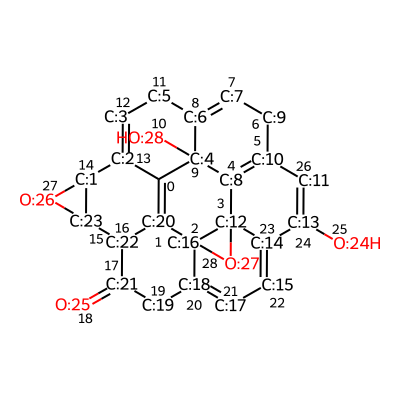

In [5]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

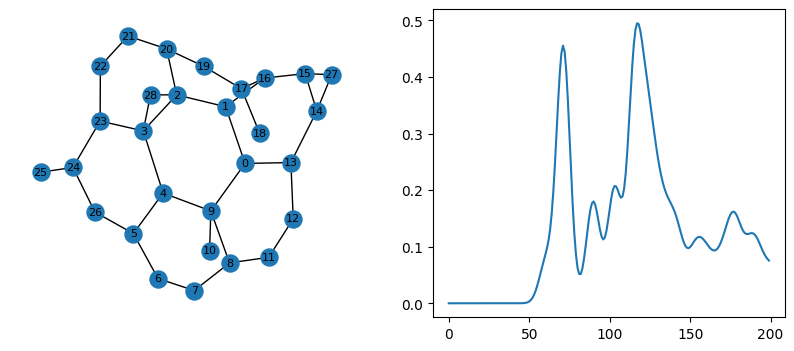

In [6]:
# --- Create subplot for 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show an atomic spectrum from molecule
ax2.plot(data.spectrum)
plt.show()

#### Split up dataset

In [46]:
# --- Split into test, validation and test
train_dataset = dataset[0:125]
val_dataset = dataset[6001:6999]
test_dataset = dataset[7000:7895]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=125, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datasets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

Length of training data loader: 125, with a total of 1 datasets
Length of validation data loader: 998, with a total of 16 datasets
Length of testing data loader: 895, with a total of 14 datasets


In [8]:
# oh, cooh, epo, ald, ket = count_funct_group(train_dataset)
# print(oh, cooh, epo, ald, ket)

In [9]:
torch.save(test_dataset, './datasets/atom_test_dataset.pt')

In [10]:
print(train_loader.dataset[0])
print(train_loader.dataset[0].atom_num)
print(train_loader.dataset[0].neighbors)

Data(x=[29, 5], edge_index=[2, 78], edge_attr=[78, 3], spectrum=[200], pos=[29, 3], z=[29], idx=[1], smiles='c12[c:4]3[c:8]4[c:12]5[c:16]6[c:20]1[C:22]1=[CH:21][CH:19]7[C:18]6([CH:17]=[CH:15][C:14]56[CH:13]([CH:11]=[C:10]4[CH2:9][CH:7]4[C:6]3([CH2:5][CH:3]3[C:2]2([CH2:1][C:23]1=[O:24])[O:27]3)[O:25]4)[O:26]6)[O:28]7', atom_num=[1], neighbors=[3])
tensor([6])
[5, 7, 23]


#### Set neural network properties

In [47]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 64, 128]
out_channels = [64, 128, 256]
gnn_type = 'gcn'
heads = int(1)
drop_ratio = 0.2
graph_pooling = 'mean'

max_degree = -1
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

deg = torch.zeros(max_degree + 1, dtype=torch.long)
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(5, 64)
      (1): GCNConv(64, 128)
      (2): GCNConv(128, 256)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=256, out_features=200, bias=True)
)
----
Training will be performed on: cpu


In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, min_lr=0.000001)

#### Run neural network training

In [50]:
num_epochs = 300
best_val_error = None
train_losses = []
val_losses = []
select = []

for epoch in range(num_epochs):
    
    # loss, a,b,c,d, out, true = train_atom(epoch, train_loader, model, device, optimizer)
    loss, out, true, train_select = train_atom(epoch, train_loader, model, device, optimizer)
    
    if epoch == 299:
        for x in train_select:
            select.append(x)

    # plt.plot(out)
    # plt.plot(true)
    # plt.ylim(-0.2, 1.2)
    # plt.xlim(0, 200)
    # plt.title(f'epoch: {epoch}')
    # plt.savefig(f'./images/training/graph_{epoch}.png')
    # plt.close()
    
    val_error, out, true, val_select = test_atom(val_loader, model, device)
    # val_error = test(val_loader)

    plt.plot(out)
    plt.plot(true)
    plt.ylim(-0.2, 1.2)
    plt.xlim(0, 200)
    plt.title(f'epoch: {epoch}')
    plt.savefig(f'./images/training/graph_{epoch}.png')
    plt.close()

    scheduler.step(val_error)
    #scheduler.step(epoch
    train_losses.append(loss)
    val_losses.append(val_error)
    
    current_lr = optimizer.param_groups[0]['lr']

    if best_val_error is None or val_error <= best_val_error:
       best_val_error = val_error

    if epoch%50 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss: {val_error:7f}, Best_ValLoss: {best_val_error:7f}')


Epoch: 000, LR: 0.010000, TrainLoss: 0.2052992, ValLoss: 0.093081, Best_ValLoss: 0.093081
Epoch: 050, LR: 0.010000, TrainLoss: 0.0256223, ValLoss: 0.020610, Best_ValLoss: 0.018947
Epoch: 100, LR: 0.010000, TrainLoss: 0.0158417, ValLoss: 0.016625, Best_ValLoss: 0.015612
Epoch: 150, LR: 0.005000, TrainLoss: 0.0117016, ValLoss: 0.013407, Best_ValLoss: 0.013217
Epoch: 200, LR: 0.005000, TrainLoss: 0.0094665, ValLoss: 0.011351, Best_ValLoss: 0.011139
Epoch: 250, LR: 0.002500, TrainLoss: 0.0081913, ValLoss: 0.010893, Best_ValLoss: 0.010827


In [16]:
frames = []

for t in range(num_epochs):
    image = imageio.v2.imread(f'./images/training/graph_{t}.png')
    frames.append(image)

imageio.mimsave('./example.gif', frames, fps=8)

In [17]:
model_name = 'model_gnn_atom_test.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

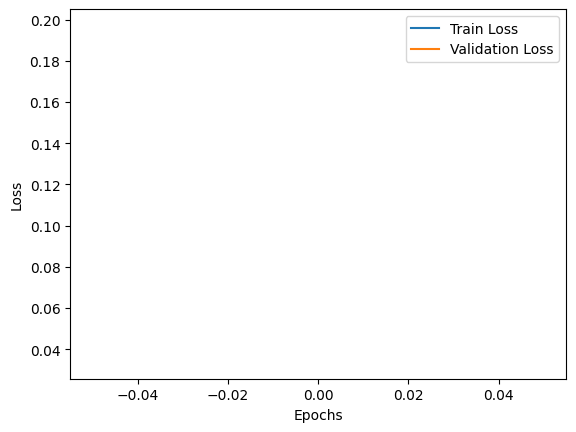

In [18]:
plot_learning_curve(num_epochs, train_losses, val_losses)

In [51]:
len(select)

125

In [58]:
train_select.shape

torch.Size([125, 256])

In [26]:
test

tensor([[-8.3548e-02,  5.2196e-01,  8.2797e-02,  ...,  0.0000e+00,
         -1.6450e+00, -7.5755e-03],
        [ 2.2854e+00, -1.2388e+00,  0.0000e+00,  ...,  8.8384e-01,
          0.0000e+00, -8.6272e-01],
        [-1.7066e-01, -1.3379e+00,  0.0000e+00,  ...,  1.5797e+00,
          3.5691e-02, -1.1707e+00],
        ...,
        [ 1.9279e-01,  3.2622e-03,  1.1451e-02,  ..., -1.5001e-01,
         -0.0000e+00, -1.0242e-01],
        [ 5.5439e-02,  1.2380e-01, -1.7277e-03,  ..., -5.1995e-02,
         -0.0000e+00,  1.8224e-01],
        [-1.8767e-01,  0.0000e+00, -5.1358e-02,  ...,  4.8571e-02,
          7.7418e-02,  8.4369e-02]], grad_fn=<CatBackward0>)

In [56]:
test = torch.cat(select, axis=1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
test.shape

torch.Size([32000])

In [60]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [61]:
transform = TSNE

In [62]:
trans = transform(n_components=2)
x_reduced = trans.fit_transform(train_select.detach().numpy())
x_reduced.shape

(125, 2)

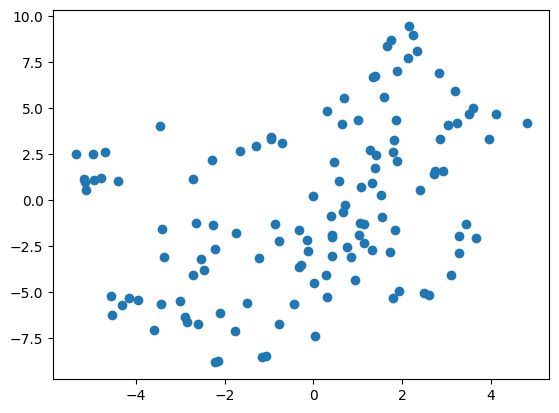

In [63]:
plt.scatter(x_reduced[:,0], x_reduced[:,1])
plt.show()

In [75]:
pca = PCA(n_components=3)
pca_fit = pca.fit(train_select.detach().numpy())

In [86]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

In [85]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(pca_fit.components_[0], pca_fit.components_[1], pca_fit.components_[2])
plt.show()

<Figure size 640x480 with 0 Axes>